In [89]:
import yfinance as yf
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [90]:
# Step 1: Download stock market data from Yahoo Finance
stock_data = yf.download('AAPL', start='2018-01-01', end='2023-01-01')

[*********************100%***********************]  1 of 1 completed


In [91]:
# Step 2: Feature Engineering
stock_data['MA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['Returns'] = stock_data['Close'].pct_change()
stock_data['Volatility'] = stock_data['Returns'].rolling(window=10).std()

In [92]:
# Drop NaN values
stock_data.dropna(inplace=True)

In [93]:
# Step 3: Shift the target variable to predict future stock prices (n days ahead)
n = 5  # Predicting 5 days ahead
stock_data['Future_Price'] = stock_data['Close'].shift(-n)

In [94]:
# Drop the last 'n' rows as they don't have future prices
stock_data.dropna(inplace=True)

In [95]:
# Step 4: Define features (X) and target (y)
X = stock_data[['MA_10', 'MA_50', 'Volatility']]  # Features
y = stock_data['Future_Price']  # Target is the future stock price

In [96]:
# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [97]:
# Step 6: Convert the data into DMatrix format for XGBoost
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

In [98]:
# Step 7: Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.3,
}

In [99]:
# Step 8: Train the XGBoost model
model = xgb.train(params, train_data, num_boost_round=100, evals=[(test_data, 'eval')], early_stopping_rounds=10)

[0]	eval-rmse:46.24157
[1]	eval-rmse:31.41760
[2]	eval-rmse:21.09995
[3]	eval-rmse:14.80571
[4]	eval-rmse:11.17232
[5]	eval-rmse:9.65147
[6]	eval-rmse:8.86741
[7]	eval-rmse:9.15990
[8]	eval-rmse:9.21604
[9]	eval-rmse:9.60414
[10]	eval-rmse:9.80209
[11]	eval-rmse:10.05502
[12]	eval-rmse:10.13466
[13]	eval-rmse:10.31923
[14]	eval-rmse:10.43061
[15]	eval-rmse:10.43605


In [100]:
# Step 9: Make predictions on the test set (future prices)
y_pred = model.predict(test_data)

In [101]:
# Step 10: Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 10.5126


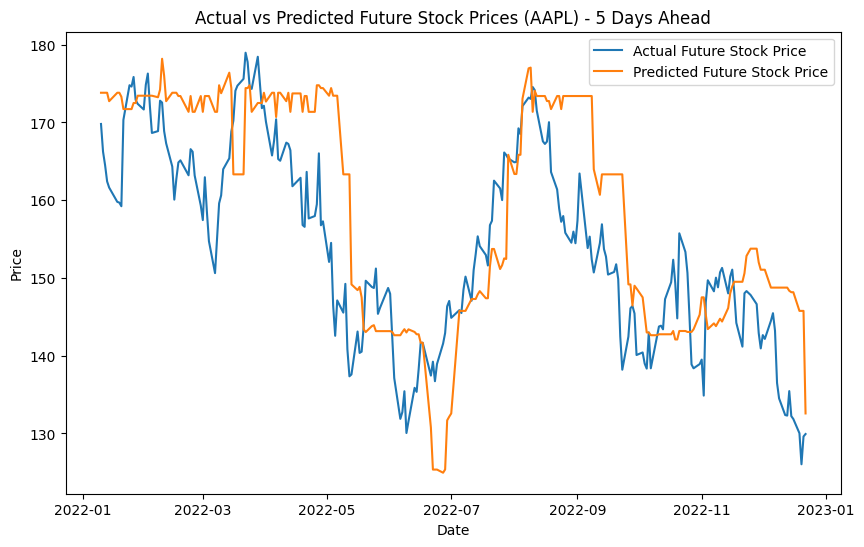

In [102]:
# Step 11: Plot the results
plt.figure(figsize=(10,6))
plt.plot(stock_data.index[-len(y_test):], y_test, label='Actual Future Stock Price')
plt.plot(stock_data.index[-len(y_pred):], y_pred, label='Predicted Future Stock Price')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"Actual vs Predicted Future Stock Prices (AAPL) - {n} Days Ahead")
plt.show()

In [104]:
# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r_squared:.2f}")

Mean Absolute Error (MAE): 8.56
Mean Squared Error (MSE): 110.52
Root Mean Squared Error (RMSE): 10.51
R-squared (R²): 0.30
